# Hands On Session: Uncovering brain-behavior relationships and overcoming overfitting with regularization

### by Adi Nair, Anderson Lab

In this section, we'll use tools learnt in Section 1 to perform dimensionality reduction such as PCA also perform decoding of behavior from neural activity using linear and logistic regression, going over important concepts such as regularization and overfitting. We'll also implement linear regression from scratch and learn about closed-form solutions. We'll be using data from the ventromedial hypothalamus (abbreviated VMHvl) from a male mouse interacting with females and males from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

🐭 🐭 🐭 


### Table of contents

#### 0) How does your data look like?
Simple exercises to plot neural and behavior data 

#### 1) Dimensionality reduction
Using sklearns' PCA to observe seperation of behavior in activity space

#### 2) Can you predict behavior from neural data?
#### 2 a) Train test splits 
A crucial process for any analysis

#### 2 b) Performing linear regression
Using sklearn's LinearRegression without any penalties

#### 2 c) Prediction and quatifying performance
Using confusion matrices to observe precision, recall & F1 scores

#### 3 a) Overcoming overfitting: LASSO or L2 Norm
Using LassoCV to perform L2 reg.

#### 3 b) Lasso model performance

#### 3 c) Overcoming overfitting: Ridge or L1 Norm
Using RidgeCV to perform L1 reg.

#### 3 d) Ridge model performance

#### 4) Class imbalance
A crucial step in classification and decoding problems

#### 5) Logistic regression
A better classification tool using sklearn's LogisticRegression

#### 6 a) Digging deeper and implementing regression from scratch
Linear regression has a closed form solution, meaning that it can be solved mathematically without optimization. Write out the math here!

#### 6 b) Testing our regression function

#### 7) Implementing regularization from scratch
Add regularization to the closed form solution

#### 8) Partial least squares regression
Find a latent dimension correlated with behavior here

In [4]:
# Import neccessary modules and helper functions

import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from matplotlib import image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale 

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    

### But first!  🐭 

A bit more about our dataset: the data you examined in part 1 comes from a head-mounting microendoscope which collected calcium imaging (GCaMP6s) data from a male mouse enaging in either mating behavior towards a female or aggressive behavior towards a male. Here we are specifically recording from estrogen 1 receptor expressing neurons in the ventromedial hypothalamus (VMHvl).

After collection of the imaging data, a data extraction pipeline is used to identify cells and extract time evolving traces from the imaging video. Finally, experimenters perform computer-vision assisted annotation of behaviors to give you the behavior label binary vectors you are using today

<center><img src="https://drive.google.com/uc?export=view&id=1ts_czT8HluZHqnr1cIUj1BNkwRfjWZoj
" alt="EMFigure" width="500"><center>

### Load data

Just as before let's load this dataset

In [7]:
remedios_data = loadmat("../../data/hypothalamus_calcium_imaging_remedios_et_al.mat");
robs = remedios_data['neural_data']
attack = remedios_data['attack_vector']
sex = remedios_data['sex_vector']


### 0) How does your data look like? 

Now that we've examined neural activity of VMHvl in session 1, let's plot both a behavior raster showing attack behavior (present in attack_vector), intruder sex (present in sex_vector) and neural activity together. 

Attack is a behavior causally linked to VMHvl activity: activation this hypothalamus brain region using optogenetic can produce aggression (see: [Lin et ., 2011, Nature](https://www.nature.com/articles/nature09736) for some cool videos)

<br>

#### Task: Generate a plot showing the behavior annotation array attack_vector, sex_vector along with neural activity below:

##### hint: use [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) as in section 1! Also try playing with the 'aspect' parameter to make the plots readable

(115, 18561) (1, 18561) (1, 18561)


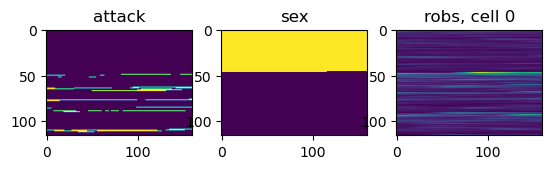

In [10]:
# Enter code here:
print(robs.shape, attack.shape, sex.shape)

plt.figure()
# Enter code here:
plt.subplot(1,3,1)
# up to the last timepoint, since it is easy to reshape this way
plt.imshow(attack[0,0:-1].reshape((116, 160)), interpolation=None)
plt.title("attack")

plt.subplot(1,3,2)
plt.imshow(sex[0,0:-1].reshape((116, 160)), interpolation=None)
plt.title("sex")
plt.subplot(1,3,3)
plt.imshow(robs[0,0:-1].reshape((116,160)))
plt.title("robs, cell 0")
plt.show()

### 1) Dimensionality reduction!
### 1 a) How seperable is behavior in a pca space?

Great! Let's now perform PCA as in section 1 and examine how sex is represented in two PCs. PCA can be easily performed in a few lines of code using sklearn's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function. This function has already been imported for you! Click the link to examine some example calls of the function and then perform PCA below:

<br>

#### Task: Generate a PCA plot colored by the behavior annotation array sex_vector using [scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) below! 
Hint: Scatter also accepts a parameter to color your plot

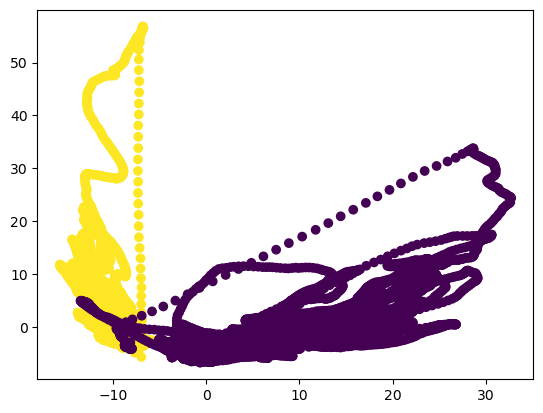

In [11]:
# Enter code here:
# make a PCA model with S = 3
pca_model_s_3 = PCA(n_components=2)

# with the PCA model instance we created to our neural data
neural_pca_s_3 = pca_model_s_3.fit_transform(robs.T)

fig = plt.figure()

# Enter code here:
pc1 = neural_pca_s_3[:,0]
pc2 = neural_pca_s_3[:,1]

plt.scatter(pc1, pc2, c=sex);

#### Success! You've recreated a key observation in [Remedios et al, 2017; see Fig 1k](https://www.nature.com/articles/nature23885/figures/1) 
Intruder sex is easily seperable within a 2D PCA space for VMHvl! 
What about other behavior? 

#### Task: Let's plot the same PCA plot but now color by the attack_vector instead:

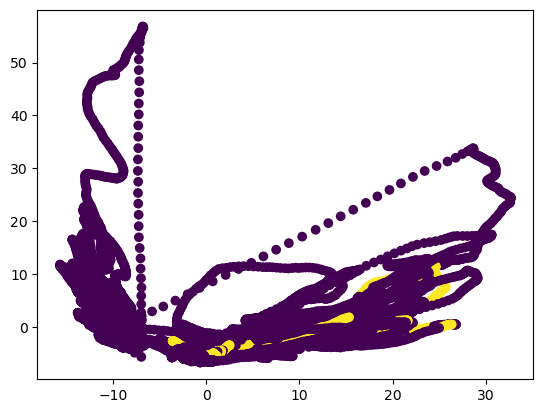

In [12]:
fig = plt.figure()

# Enter code here:
pc1 = neural_pca_s_3[:,0]
pc2 = neural_pca_s_3[:,1]

plt.scatter(pc1, pc2, c=attack);

### 2) Can you predict behavior from neural data?

Attack behavior is fairly rare in our dataset, let's train a simple linear regression model to estimate if attack can be decoded from this population before we move to methods like partial least squares.

In regression, we predict the behavior as a linear combination of the activity of neurons, as follows: $y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$.

where $y$ is the behavior we predict and $x_1, x_2, ... , x_n$ are the activities of individual neurons at a given time point.

### 2 a) Make a Train Test Split

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set.

#### Task: Generate a train-test split in your dataset below (hint: use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn)

#### For this exercise, set the shuffle parameter to False

In [75]:
# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T, 
                                             test_size=0.33, shuffle = False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12435, 115), (6126, 115), (12435, 1), (6126, 1))

### 2 b) Performing regression

We will use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module to perform the actual regression. 

This can be implemented in just a single line of code thanks to sklearn! 

#### Task: Generate a regression model using sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function

In [76]:
# Enter code here:
reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### 2 c) How well is your model performing?

To quantify performance, we can use a confusion matrix with quantifies the degree of false positives and false negative for each class (attack and not-attack). These metrics can then be used to calculate an accuracy and precision value for each class. We use sklearn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) module to perform this. 
<br>

<center><img src="https://drive.google.com/uc?export=view&id=1MUZDHf9xFvyBNrGGAvlo1scNQwzIu0-1
" alt="EMFigure" width="500"><center>

Keep in mind, the output of regression will be a number, not a class label. This output represents a probability (but can be negative since linear regression does not impose non-negativity). We need to threshold the output by a value (say 0.4 as an example) to generate a binary signal that be compared with attack_vector.
<br>
    
#### Use sklearn's [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to quantify performance of your linear model

Note: confusion matrix by default provides counts, this needs to be normalized either row-wise or column-wise. Try both below. Which is better?

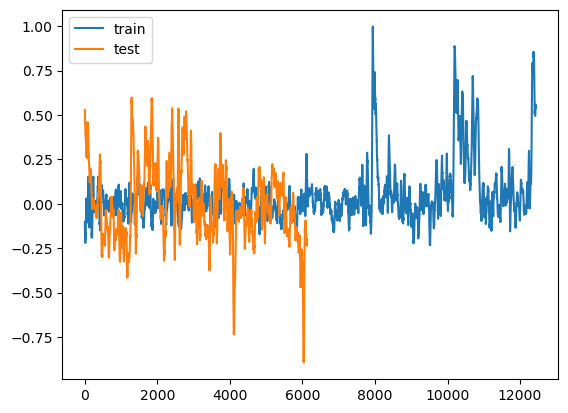

In [77]:
# Enter code here
# Enter code here
pred_train = reg.predict(X_train)
plt.plot(pred_train, label='train')

pred_test = reg.predict(X_test)
plt.plot(pred_test, label='test')

plt.legend()

Train
[[0.99551911 0.17298188]
 [0.00448089 0.82701812]]
Test
[[0.92214237 0.65602837]
 [0.07785763 0.34397163]]


Text(0.5, 1.0, 'regression test performance for attack')

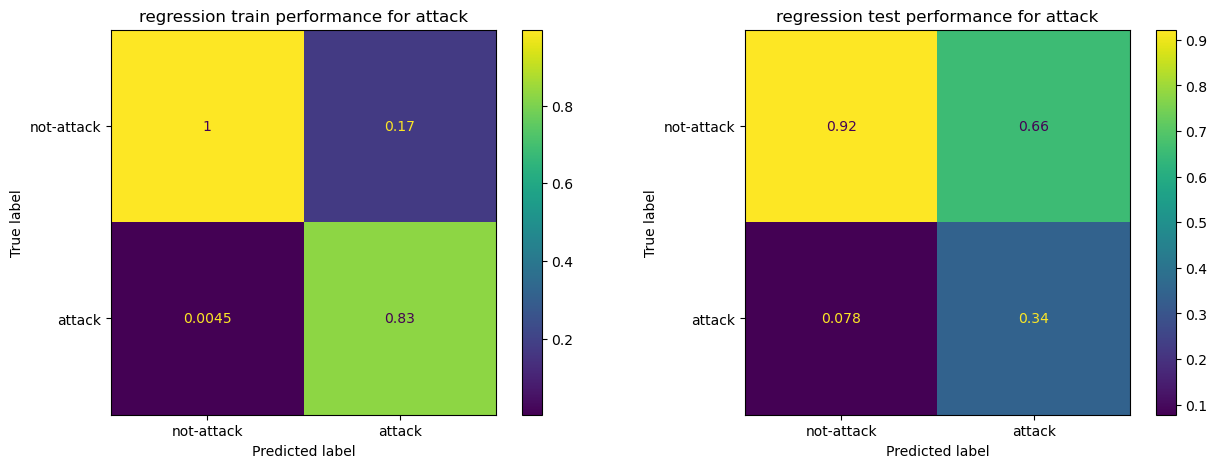

In [80]:
thresh = 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train > thresh, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test > thresh, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train, 
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test, 
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

# it's easy to increase precision here by just increasing what is OK to include
# but, I think this would destroy recall 

This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses.

Let's also observe this as a behavior raster:

<br>

#### Task: Create a plot showing both the predicted behavior raster (the binary vector obtained after thresholding regression output) and the actual behavior raster for attack (attack_vector)

Text(0, 1.5, 'other frames')

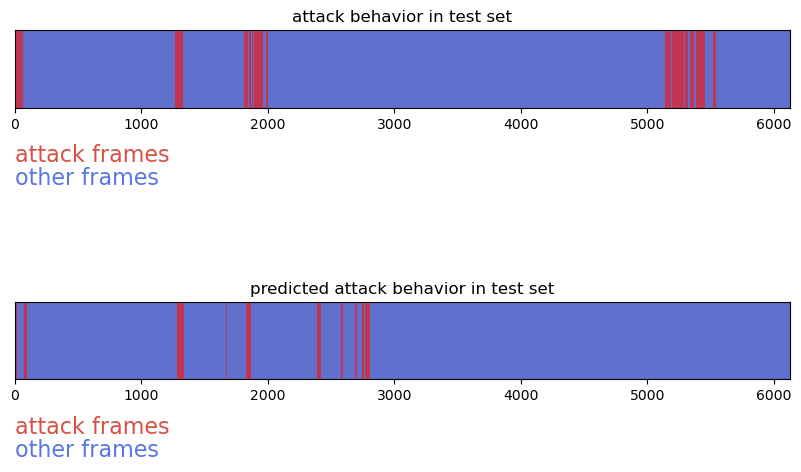

In [88]:
# Enter code here:
# behavior raster is the activity plotted over time (with imshow)

cmap = matplotlib.cm.get_cmap('coolwarm')

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(pred_test.T > thresh, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 ) How can we overcome overfitting?

### 3 a) LASSO or L2 Regularization

To overcome overfitting, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exist, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to enforce sparsity in predicted weighted from linear regression. LASSO is also known as L2 norm regularization.

Most methods in machine learning always involving comparing a data point with it's predicted value. This can be written as: $y - \beta x $ in the case of linear regression. The goal of machine learning is to estimate a value of $\beta$ that minimizes this error that we also call a loss function. In regularization, we apply a penalty to this error, which for LASSO is as follows:

$(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

The value of lamba specifies the amount of regularization. Lasso created sparse weights, if a variable has no predictive power in the regression problem, Lasso applies a zero weight to such variables. How lasso achieves this can be understood from a geometric interpretation of weights, read more about it [here]() [maybe here instead](https://stats.stackexchange.com/questions/351524/what-is-the-geometric-explanation-for-high-variance-overfitting-bad-generali). The strength of sparisity depends on the value of $\alpha$

### How do we select the right model?

The value of lamba is selected by cross-validation, a process where the training data is split into several 'folds' or portions and the model is trained on some folds and tested on the held-out fold. This is a process called model selection and is vital to most ML methods.

Lasso can be implemented using sklearn's [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). 

#### Task: Read the help sklearn [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) help page and generate a lasso model with cross validation below. Make a plot showing model performance against $\alpha$ value using cross validation (called model selection plot) below:

/opt/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


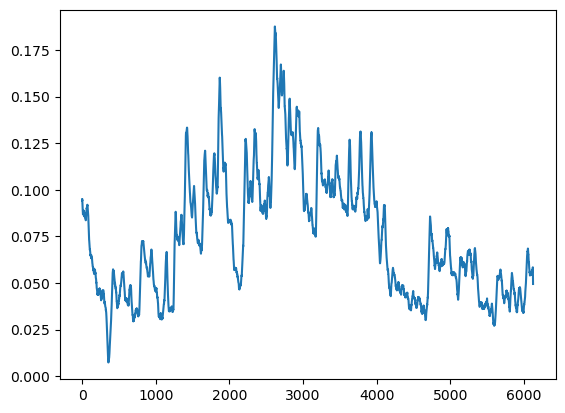

In [124]:
# Enter code here
# a.k.a. L2 norm regularization
lasso = sklearn.linear_model.LassoCV()
lasso.fit(X_train, y_train)
plt.plot(lasso.predict(X_test))

### 3 b) Lasso model performance

#### Task: Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

Train
[[0.966759  0.6954023]
 [0.033241  0.3045977]]
Test
[[0.90948045 0.91428571]
 [0.09051955 0.08571429]]


Text(0.5, 1.0, 'regression test performance for attack')

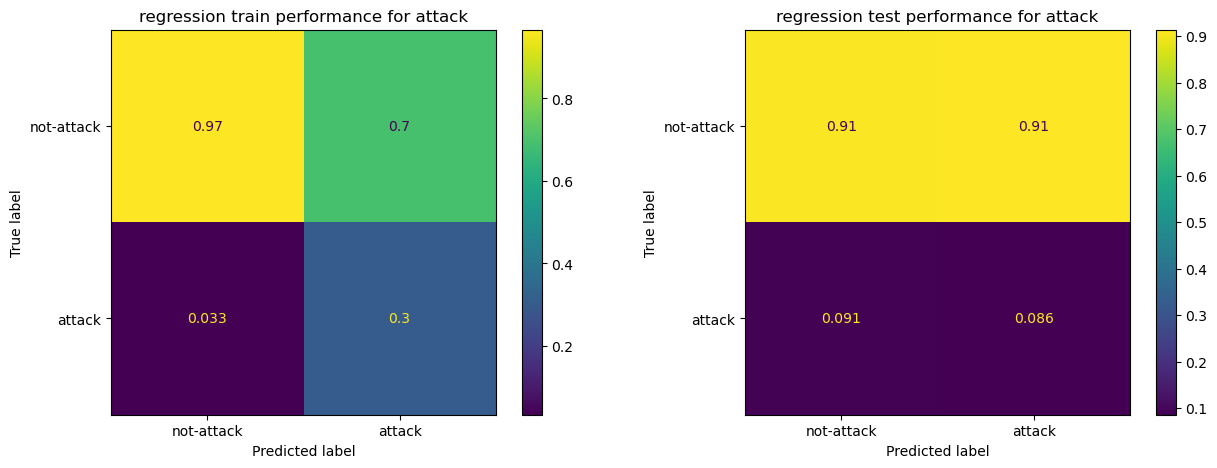

In [122]:
# Enter code here:
pred_train = lasso.predict(X_train) > 0.125
pred_test = lasso.predict(X_test) > 0.125

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

# it's easy to increase precision here by just increasing what is OK to include
# but, I think this would destroy recall 

#### Let's also visualize the predicted and actual ocurrences of attack behavior in the test set below

#### Task: Generate a behavior plot for both predicted and actual occurence of attack below

Text(0, 1.5, 'other frames')

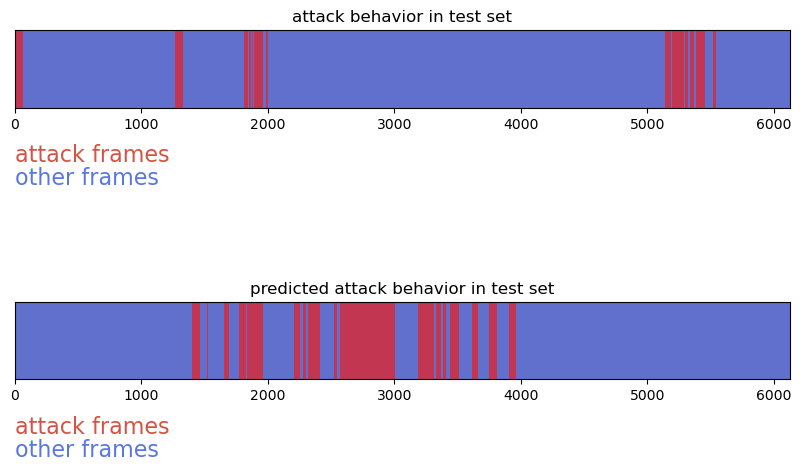

In [123]:
#Enter code here:
pred_train = pred_train.reshape((12435,1)).T
pred_test = pred_test.reshape((6126,1)).T

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(pred, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 c) Overcoming overfitting: Ridge or L1 Norm

#### Oh no! LASSO isn't sufficient 😞 

No worries, let's try another type of reglurization! Like LASSO (or L2 norm), a second type of regularization called Ridge (or L1 norm) might be useful here!:

In LASSO, we added a penalty to our regression problem as follows:

LASSO or L2 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

In Ridge, we add a slightly different penalty: 

Ridge or L1 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} \beta_i^2 $

Unlike Lasso which creates sparsity, ridge scales weights and reduces their overall value.

Explain more about Ridge regression [here]()

#### Let's implement Ridge Regression using sklearn's RidgeCV method, once again the $\alpha$ parameter is determined by cross validation


#### Note: unlike LassoCV, we need to provide a list of $\alpha$ values for Ridge CV. As a first example, try values from 0-200 in intervals of 1.

#### Task: Perform Ridge regression and create a model selection plot showing model performance against values for  $\alpha$

Text(0.5, 1.0, 'model selection for ridge')

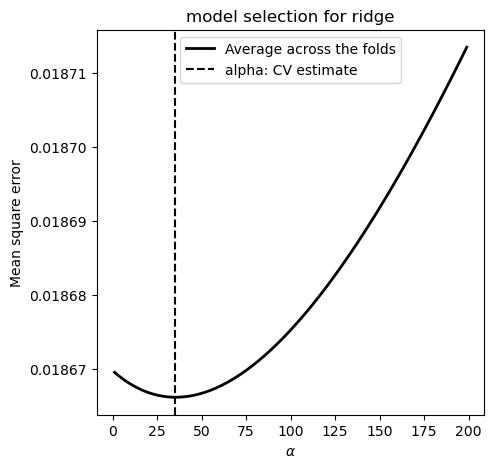

In [134]:
# Enter code here:
ridge = sklearn.linear_model.RidgeCV(
    alphas=np.arange(1,200,1.0),
    store_cv_values=True)

ridge.fit(X_train, y_train)

plt.figure(figsize=(5, 5))
plt.plot(
    ridge.alphas,
    ridge.cv_values_.mean(axis=0).reshape(199),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

# alpha with lowest error
plt.axvline(ridge.alpha_ , linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for ridge")

### 3 d) Ridge model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

Train
[[0.99551949 0.17161716]
 [0.00448051 0.82838284]]
Test
[[0.92201129 0.65591398]
 [0.07798871 0.34408602]]


Text(0.5, 1.0, 'regression test performance for attack')

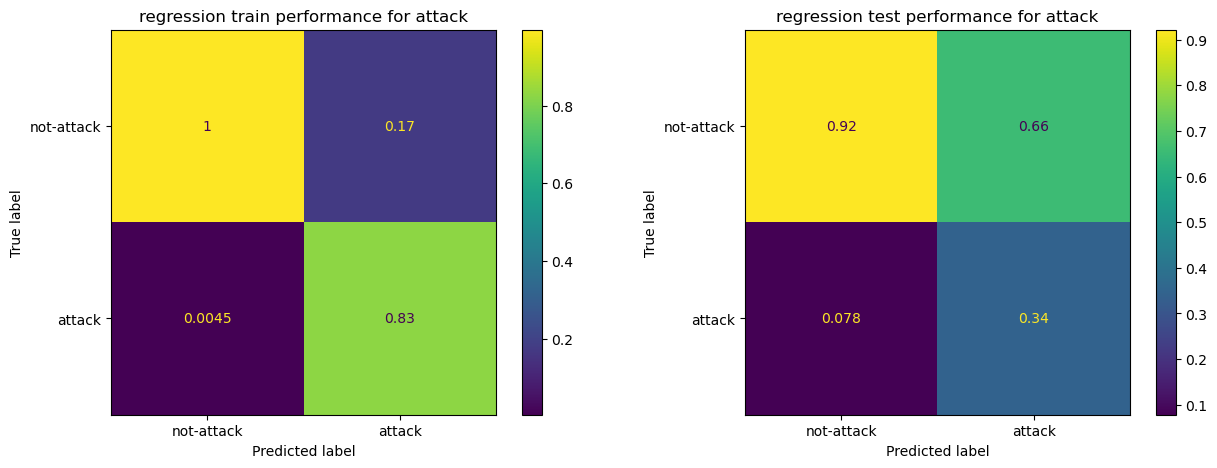

In [136]:
# Enter code here:
pred_train = ridge.predict(X_train) > 0.4
pred_test = ridge.predict(X_test) > 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

# it's easy to increase precision here by just increasing what is OK to include
# but, I think this would destroy recall 

### 4) Class Imbalance

#### okay... so we're doing a little better than before, but still not perfect!

### Notice something about our data, our train & test splits contain very few examples of the label 'attack'! This problem called [class imbalance]() is very detrimental to our problem! 

There are two ways to fix this: We can either shuffle our data to ensure that the 'attack' label is uniformly sprinkled throughout the data or we can sub-sample our data to include equal numbers of attack and not-attack labels. We'll try the latter approach in session 3 today, for now let's try the former
!
Hint: It's as simple as including an argument in the function train_test_split

#### Task: Redo regression (either Ridge or LASSO), but now including shuffled or sub-sampled classes below
#### For shuffling data to uniformly distribute attack labels, add shuffle=True when calling train_test_split

Train
[[0.99300276 0.20488941]
 [0.00699724 0.79511059]]
Test
[[0.99317705 0.25853659]
 [0.00682295 0.74146341]]


Text(0.5, 1.0, 'regression test performance for attack')

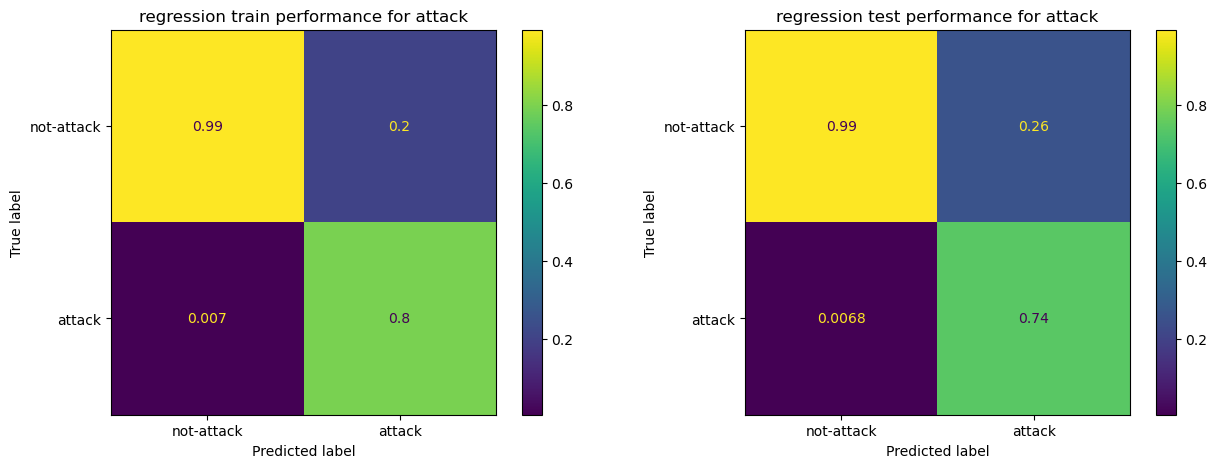

In [138]:
# Enter code here:

# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T,
                                             test_size=0.33, 
                                             shuffle = True, 
                                             random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



ridge = sklearn.linear_model.RidgeCV(alphas=np.arange(1,200,1.0))
ridge.fit(X_train, y_train)

# Enter code here:
pred_train = ridge.predict(X_train) > 0.4
pred_test = ridge.predict(X_test) > 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

# it's easy to increase precision here by just increasing what is OK to include
# but, I think this would destroy recall 

### YAY!! Our decoder works!!  🎉🎉🎉

Let's finally make a plot showing our entire dataset: the attack annotation, neural data and predicted attack labels on all data

Text(0, 0.5, 'neurons')

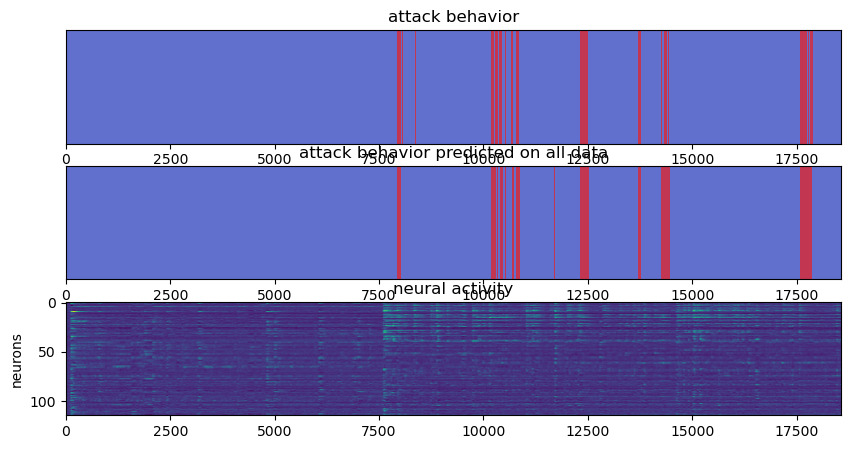

In [155]:
# Enter code here:
# Solution: 

# plot neural activity, showing frames of attack
all_y_pred = ridge.predict(robs.T)
all_y_pred_bin = np.zeros((1,np.size(robs[0,:])))
all_y_pred_bin[0,np.where(all_y_pred>0.4)] = 1

plt.figure(figsize=[10,5])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('coolwarm')

ax1.imshow(attack, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
#forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')

ax2 = plt.subplot(312)
ax2.imshow(all_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
#forceAspect(ax1,aspect=10)
ax2.set_yticks([])
ax2.set_title('attack behavior predicted on all data')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=14)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=14)

ax3 = plt.subplot(313)
ax3.imshow(robs, aspect='auto')
ax3.set_title('neural activity')
ax3.set_ylabel('neurons')

# this only seemed to make things worse for some reason...
#plt.tight_layout()

### 5) Can we get better at predicting behavior?

### 5 a) Logistic Regression

Linear regression is a great simple tool to quantifying correlations between neural activity and behavior. However, the output of regression wasn't a class label. Other methods such as logistic regression (and many others such as SVMs & Random Forests that we will cover in later tutorials) are better suited to classification problems.

Logistic regression adds a non-linear step between your prediction and coefficients. We start with a linear function: $f(x) = \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n $ which is then passed into a sigmoid function $p(x) = 1/(1+exp(-f(x))$. Thus the output of logistic regression is a probability between 0-1 of the prediction. This can be thresholded to produce a class label.

sklearn makes it very easy to perform Logistic regression using [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that performs a built-in regularization step. Methods like logistic regression are more powerful than Linear regressison and can find an accurate solution sometimes even in the presence of a class imbalance

#### Note: Unlike linear regression, logistic regression directly gives us a label as output. Thresholding isn't required by default

#### Task: Implement Logistic Regression using sklearn below

/opt/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

Train
[[0.99802863 0.03515625]
 [0.00197137 0.96484375]]
Test
[[0.99603038 0.03614458]
 [0.00396962 0.96385542]]


/opt/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'regression test performance for attack')

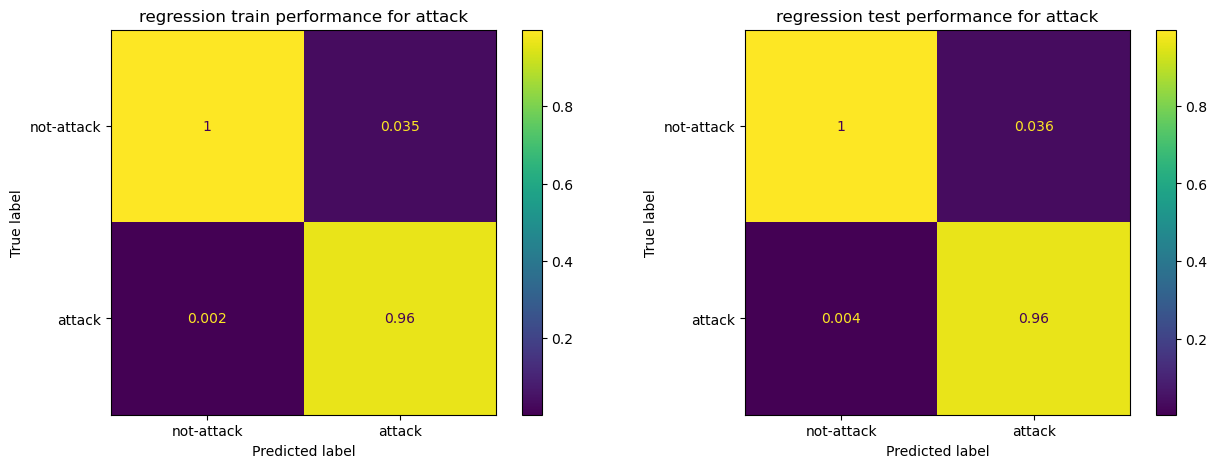

In [158]:
# Enter code here:
# Enter code here:

# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T,
                                             test_size=0.33,
                                             shuffle = True,
                                             random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



logistic = sklearn.linear_model.LogisticRegressionCV()
logistic.fit(X_train, y_train)

# Enter code here:
pred_train = logistic.predict(X_train)
pred_test = logistic.predict(X_test)

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

# it's easy to increase precision here by just increasing what is OK to include
# but, I think this would destroy recall 

### How does linear regression work?

### 6 a) Digging deeper and implementing regression from scratch:

We've implemented linear regression with sklearn's helpful functions, but how does regression actually work?

Let's gain an understanding by coding out the steps behind regression.
As we saw earlier, the goal of regression is to predict a variable y (behavior) as a linear combination of x (neural activity). This can be written as:

$y = \beta X$

Notice here that we switch to matrix notation, here $\beta$ is no longer a single number but a vector as long as the number of neurons (n). Hence it's dimensionas as $(1 x n)$. X here is also a matrix with dimensions $(n x t)$, where t is the number of time points.

There are many algorithms that allow us to find the $\beta's$ that make our weights. Some methods are iterative, using a loss function as defined earlier and reducing error over time. Luckily, linear regression also has an analytical solution which can be implemented in a single step!

The solution here is simply: 

$\beta = (X^{T} X)^{-1} X^{T} y$

Why is that?? We'll explain later but if you're curious you can read about the mathematical steps [here](https://dustinstansbury.github.io/theclevermachine/derivation-normal-equations):

Let's try this out!

We're going to use [Object Oriented Programming](https://en.wikipedia.org/wiki/Object-oriented_programming) here and create a class which can implement this solution for us 

#### Fill in the function below to implement linear regression 

In [183]:
# Enter code here

class LinearRegClosedSolution(object):
    def __init__(self):
        self.betas = []
        
    def fit(self, X, y):
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.T@X) @ (X.T@y) # Enter equation for beta here
        
    def predict(self, X):
        b = self.betas
        # Enter equation for finding solution here
        print(b[1:].T.shape, X.T.shape)
        prediction = (b[1:].T @ X.T) + b[0]
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 6 b) Testing our regression function!

Now that we've implemented linear regression, let's test it out! 

Split the data into train and test folds and use the class created above to implement linear regression

#### Try that below!

In [187]:
# Enter code to perform regression here:
# Enter code here:

# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T,
                                             test_size=0.33,
                                             shuffle = True,
                                             random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



mylinear = LinearRegClosedSolution()
mylinear.fit(X_train, y_train)

# Enter code here:
pred_train = mylinear.predict(X_train) > 0.4
pred_test = mylinear.predict(X_test) > 0.4

(1, 115) (115, 12435)
(1, 115) (115, 6126)


#### Now predict the test data using our closed form function and generate a confusion matrix

Train
[[0.99317259 0.20717593]
 [0.00682741 0.79282407]]
Test
[[0.99317943 0.25490196]
 [0.00682057 0.74509804]]


Text(0.5, 1.0, 'regression test performance for attack')

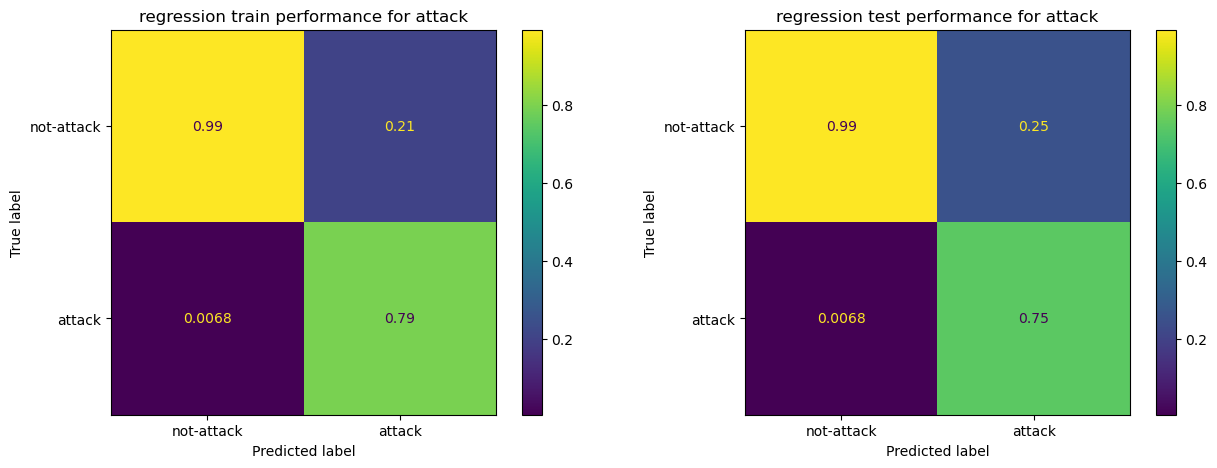

In [191]:
# Enter code here:
confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train.T, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test.T, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 7) Yay! Our closed form regression works 🎉🎉🎉

Let's also try fitting a regularized version of the closed form solution.

Ridge regression is a form of regularization that possess an analytical solution which is as follows:

$\beta = (X^{T} X + \lambda I)^{-1} X^{T} y$

where $\lambda$ is a parameter we need to determine using cross validation once more!

Let's implement a function to perform ridge regression below:

#### Implement a ridge regression class below where you can feed in a single regularization parameter $\lambda$:

In [200]:
# Enter code here
class LinearRegRidgeClosedSolution(object):
    def __init__(self):
        self.betas = []

    def fit(self, X, y, regLamba):
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.T@X + regLamba*np.eye(1, X.shape[1])) @ (X.T@y) # Enter equation for beta here

    def predict(self, X):
        b = self.betas
        # Enter equation for finding solution here
        print(b[1:].T.shape, X.T.shape)
        prediction = (b[1:].T @ X.T) + b[0]
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 7 b) Testing our regression function!

Now that we've implemented linear regression with regularization, let's test it out! 

#### Split the data into train and test folds and use the class created above to implement linear regression


In [201]:
# Enter code here
# Enter code to perform regression here:
# Enter code here:

# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T,
                                             test_size=0.33,
                                             shuffle = True,
                                             random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



mylinear = LinearRegRidgeClosedSolution()
mylinear.fit(X_train, y_train, regLamba=0.1)

# Enter code here:
pred_train = mylinear.predict(X_train) > 0.4
pred_test = mylinear.predict(X_test) > 0.4

(1, 115) (115, 12435)
(1, 115) (115, 6126)


#### Now predict the test data using our closed form function and generate a confusion matrix

Train
[[0.99317259 0.20717593]
 [0.00682741 0.79282407]]
Test
[[0.99317943 0.25490196]
 [0.00682057 0.74509804]]


Text(0.5, 1.0, 'regression test performance for attack')

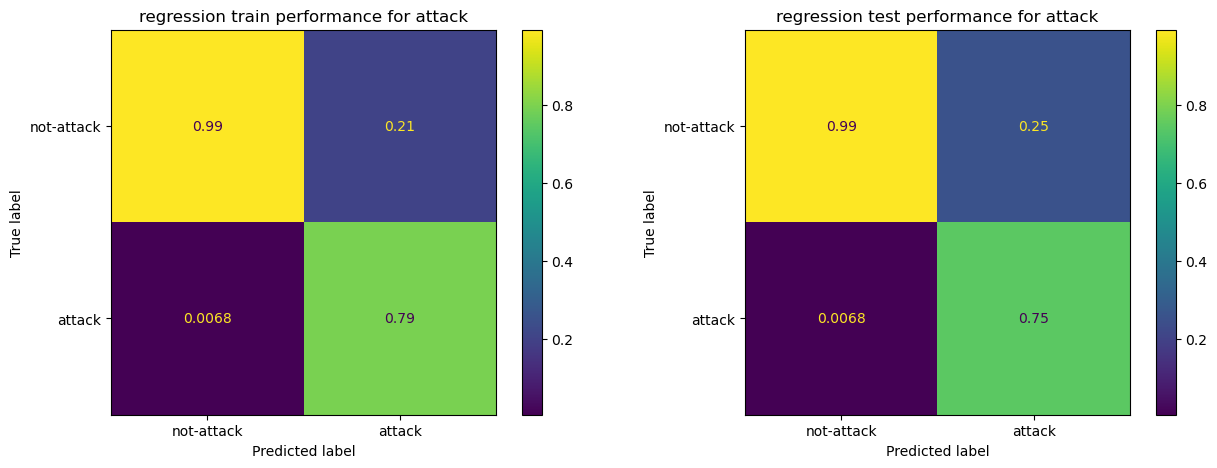

In [202]:
# Enter code here:
confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train.T, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test.T, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 8) What if you want to perform dimensionality reduction and regression jointly?

### 8 a) cue Partial least squares regression (PLS)!

PLS acts as both a dimensionality reduction method and a classification tool. It decomposes neural data into a given number of factors and then uses those factors for classifying a particular variable such as a behavior. 

sklearn once comes to the rescue with a built in implementation in the form of [PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html).

PLSRegression is applied as any other regression technique. You can reuse your code above to generate train, test splits and perform cross validation using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to CV your model. After classification, use the model.x_scores_ to access the latent representations that are most prediction of the behavior here!

#### Task: Perform PLS and plot classification performance below:

Train
[[0.97086641 0.29342327]
 [0.02913359 0.70657673]]
Test
[[0.97378341 0.34482759]
 [0.02621659 0.65517241]]


Text(0.5, 1.0, 'regression test performance for attack')

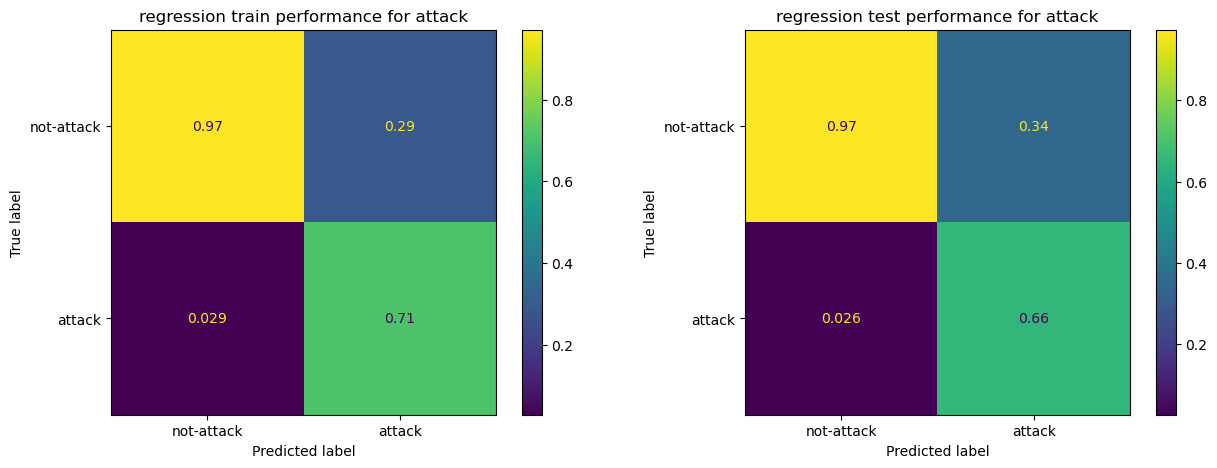

In [209]:
# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, attack.T,
                                             test_size=0.33,
                                             shuffle = True,
                                             random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



plsregression = sklearn.cross_decomposition.PLSRegression(n_components=3)
plsregression.fit(X_train, y_train)

# Enter code here:
pred_train = plsregression.predict(X_train) > 0.4
pred_test = plsregression.predict(X_test) > 0.4

# Enter code here:
confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

Unlike linear regression, PLS attempts to find dimensions that maximize variance as well as their correlation to an external variable such as behavior. Thus, the PLS model performance comes close to regression but is not as high as it. 

What do the PLS dimensions look like? This can be found in parameter - pls.x_scores_

In [210]:
plsregression.x_scores_.shape

(12435, 3)


### As the final part of this notebook, run PLS on the entire dataset and plot the 1st PLS component along with a behavior raster and neural data and also plot the output of a regression method (such as ridge)


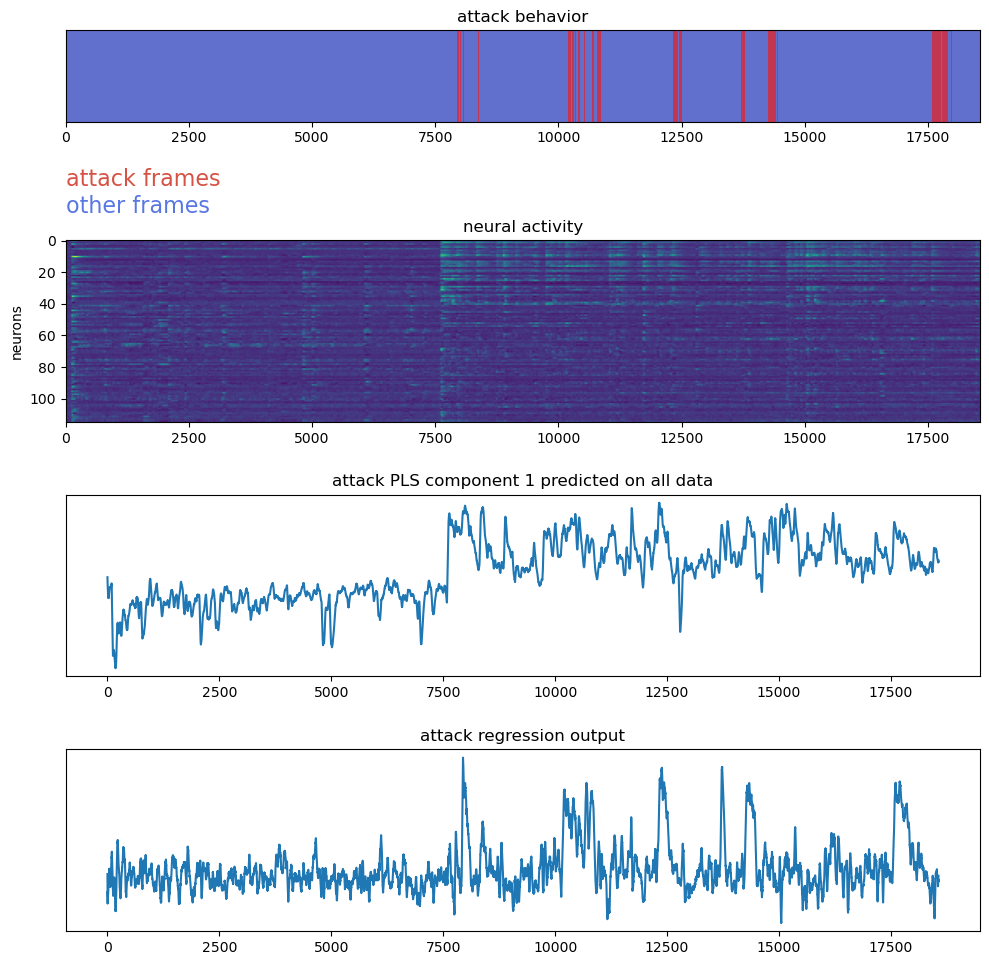

In [207]:
# Enter code here
# Solution: 

alphas = np.arange(1,200,1.0)

pls = PLSRegression(n_components=3)
pls.fit(robs.T, attack[0])
ridge = RidgeCV(alphas, store_cv_values=True).fit(robs.T, attack[0])

plt.figure(figsize=[10,10])
ax1 = plt.subplot(411)
cmap = matplotlib.cm.get_cmap('coolwarm')

ax1.imshow(attack, aspect='auto', alpha = 0.8, interpolation = 'nearest',cmap=cmap)
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(412)
ax2.imshow(robs, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(413)
ax3.plot(pls.x_scores_[:,0])
ax3.set_yticks([])
ax3.set_title('attack PLS component 1 predicted on all data')

ax3 = plt.subplot(414)
train_y_pred = ridge.predict(robs.T)
ax3.plot(train_y_pred)
ax3.set_yticks([])
ax3.set_title('attack regression output')

plt.tight_layout() 